In [1]:
import model
import data_loaders
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [12]:
T = 5                  # Number of time steps
H, W = 32, 32        # Spatial dimensions
N_half = 100            # Number of samples per case (SSH and OBP)
C_in = 2               # SSH and OBP channels
C_out = 4              # Number of output channels (e.g., SSH, OBP, and two additional channels)
N = 2 * N_half         # Total number of samples
embed_dim = 8          # Embedding dimension for cost function
wet = torch.ones((H, W), dtype=torch.float32)  # Example wet mask (1 for wet, 0 for dry)

In [ ]:
x = torch.zeros((N, T, C_in, H, W))
labels = torch.cat([torch.ones(N_half), torch.zeros(N_half)]).long()  # 1=SSH, 0=OBP    #or None

torch.manual_seed(0)
spatial_indices = torch.randint(0, H * W, (N_half,))
centers = [(idx // W, idx % W) for idx in spatial_indices]

# Helper function to get neighborhood bounds at time t
def get_neighbors(center, t, H, W):
    i, j = center
    r = t  # radius grows with time
    return max(i - r, 0), min(i + r + 1, H), max(j - r, 0), min(j + r + 1, W)

In [14]:
# Build x for J = SSH (label = 1)
for i in range(N_half):
    center = centers[i]
    for t in range(T):
        i_min, i_max, j_min, j_max = get_neighbors(center, t, H, W)
        if t == 0:
            # At t=0, only ∂J/∂SSH has 1 at center
            x[i, t, 0, center[0], center[1]] = 1.0
            x[i, t, 1, :, :] = 0.0
        else:
            # Later times: growing neighborhood in both SSH and OBP channels
            x[i, t, 0, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1
            x[i, t, 1, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1

In [15]:
# Build x for J = OBP (label = 0)
for i in range(N_half):
    center = centers[i]
    for t in range(T):
        i_min, i_max, j_min, j_max = get_neighbors(center, t, H, W)
        if t == 0:
            # At t=0, only ∂J/∂OBP has 1 at center
            x[N_half + i, t, 1, center[0], center[1]] = 1.0
            x[N_half + i, t, 0, :, :] = 0.0
        else:
            # Later times: growing neighborhood in both SSH and OBP channels
            x[N_half + i, t, 0, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1
            x[N_half + i, t, 1, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1

In [16]:
y = torch.zeros((N, T, C_out, H, W))  # Allocate output tensor

# First two channels from shifted x
y[:, :-1, 0, :, :] = x[:, 1:, 0, :, :]  # dJ/dSSH_t   ← x[:, t+1, 0]
y[:, :-1, 1, :, :] = x[:, 1:, 1, :, :]  # dJ/dOBP_t   ← x[:, t+1, 1]

for i in range(N):
    center = centers[i % (N // 2)]  # same center reused for J=SSH and J=OBP
    t = T-1
    i_min, i_max, j_min, j_max = get_neighbors(center, t, H, W)
    y[i, t, 0, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1
    y[i, t, 1, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1

In [17]:
# Generate forcing adjoints for tau_u and tau_v
for i in range(N):
    center = centers[i % (N // 2)]  # same center reused for J=SSH and J=OBP
    for t in range(T):
        i_min, i_max, j_min, j_max = get_neighbors(center, t, H, W)
        y[i, t, 2, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1
        y[i, t, 3, i_min:i_max, j_min:j_max] = torch.rand(i_max - i_min, j_max - j_min) * 2 - 1

In [18]:
# Split train and test datasets
N, T, C_in, H, W = x.shape  # N= total number of spatial points * 2 (one for SSH and one for OBP)
C_out = y.shape[2]  # Number of output channels
test_percent = 0.2
train_frac = 1.0 - test_percent
n_train = int(train_frac * N)
n_test = int(test_percent * N)

In [19]:
# Optional: shuffle indices with reproducibility
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(N, generator=generator)
x_shuffled = x[indices]
y_shuffled = y[indices]
labels_shuffled = labels[indices]

x_train, x_test = torch.split(x_shuffled, [n_train, n_test])
y_train, y_test = torch.split(y_shuffled, [n_train, n_test])
labels_train, labels_test = torch.split(labels_shuffled, [n_train, n_test])

embedder = model.CostFunctionEmbedding(enc_dim=2, embed_dim=embed_dim, spatial_shape=(H, W))
train_dataset = data_loaders.AdjointDataset(x_train, y_train, labels_train)
test_dataset  = data_loaders.AdjointDataset(x_test, y_test, labels_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
if labels is not None:
    model_adj = model.AdjointModel(backbone=model.AdjointNet(wet, in_channels=C_in+embed_dim, out_channels=C_out))  # insert args
    optimizer = torch.optim.AdamW(list(model_adj.parameters()) + list(embedder.parameters()), lr=1e-4, weight_decay=1e-5)
else:
    model_adj = model.AdjointModel(backbone=model.AdjointNet(wet, in_channels=C_in, out_channels=C_out))  # insert args
    optimizer = torch.optim.AdamW(model_adj.parameters(), lr=1e-4, weight_decay=1e-5)

In [21]:
model.train_adjoint_model(
    model=model_adj,
    dataloader=train_loader,
    optimizer=optimizer,
    val_loader=test_loader,
    num_epochs=1000,
    patience=100,
    label_embedder=embedder,
    save_path="best_model.pt",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

check training
check training
check training
check training
check training


KeyboardInterrupt: 

# Plots

In [55]:
import matplotlib.pyplot as plt

def plot_adjoint_slices(y, idx_n, idx_c, i=0, title_prefix="Adjoint"):
    """
    Plot 4 consecutive time slices from y[idx_n, i:i+4, idx_c, :, :]

    Args:
        y: torch.Tensor of shape (N, T, C_out, H, W)
        idx_n: int, index into the sample dimension (N)
        idx_c: int, index into the output channel (0–3)
        i: int, starting time index (default=0)
        title_prefix: str, prefix for subplot titles
    """
    assert i + 4 <= y.shape[1], "Not enough time steps to plot 4 slices"

    slices = y[idx_n, i:i+4, idx_c, :, :].cpu().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for j in range(4):
        ax = axes[j]
        im = ax.imshow(slices[j], origin='lower', cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f"{title_prefix} t-{i+j}")
        ax.axis('off')
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.01)
    plt.tight_layout()
    plt.show()

/var/folders/1t/drmp335n0fb0xt1jf2h76c640000gq/T/ipykernel_24619/1934727317.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


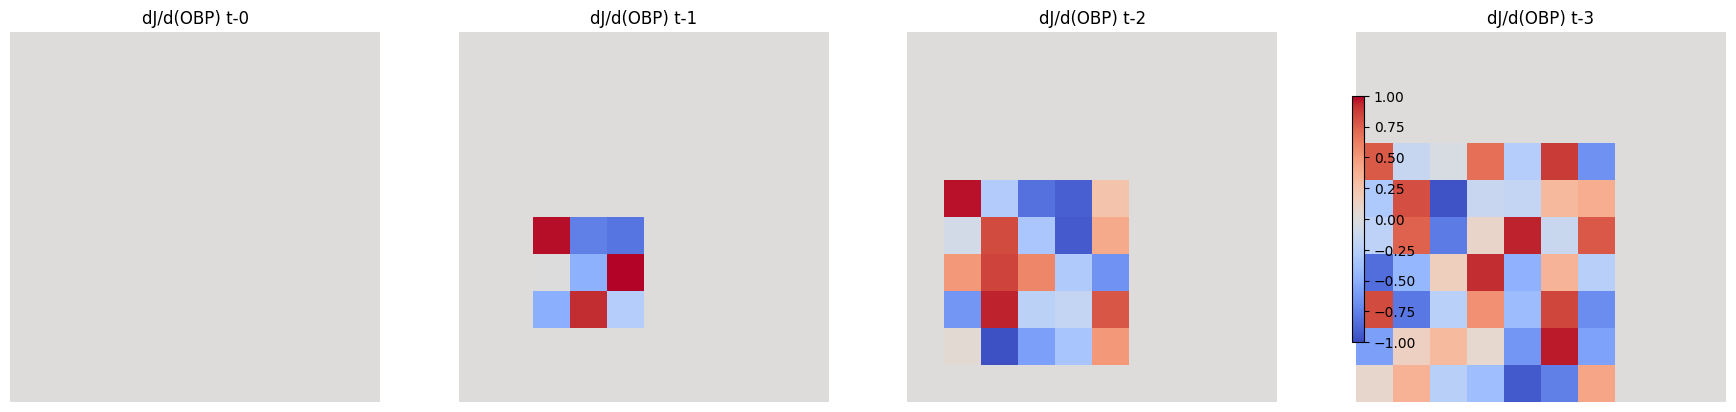

In [59]:
plot_adjoint_slices(x, idx_n=2, idx_c=1, i=0, title_prefix="dJ/d(OBP)")

In [57]:
centers

[(tensor(4), tensor(4)),
 (tensor(3), tensor(9)),
 (tensor(3), tensor(3)),
 (tensor(6), tensor(0)),
 (tensor(6), tensor(3)),
 (tensor(7), tensor(9)),
 (tensor(2), tensor(7)),
 (tensor(0), tensor(3)),
 (tensor(9), tensor(7)),
 (tensor(8), tensor(3))]